In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load Fashion MNIST dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [3]:
# Normalize pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [4]:
# Add a channel dimension for Conv2D: (batch_size, 28, 28, 1)
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [5]:
# Add random noise to input images (Denoising Autoencoder)
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

In [6]:
# Clip values to keep them in [0, 1]
x_train_noisy = tf.clip_by_value(x_train_noisy, 0., 1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, 0., 1.)

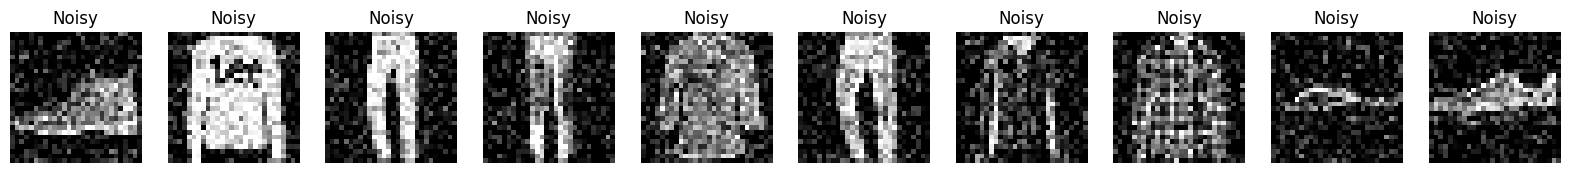

In [7]:
# Visualize noisy inputs
plt.figure(figsize=(20, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(tf.squeeze(x_test_noisy[i]), cmap="gray")
    plt.title("Noisy")
    plt.axis("off")
plt.show()

In [8]:
# Define Convolutional Denoising Autoencoder
class DenoisingAutoencoder(Model):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder part
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
        ])
        # Decoder part
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, (3, 3), strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
# Create model instance
autoencoder = DenoisingAutoencoder()

In [10]:
# Compile the model with MSE loss and Adam optimizer
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [11]:
# Define early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [12]:
# Train the autoencoder on noisy inputs and original images as targets
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stop]
)


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - loss: 0.0774 - val_loss: 0.0140
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 0.0133 - val_loss: 0.0119
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.0114 - val_loss: 0.0108
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.0101 - val_loss: 0.0099
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 12/20
469/469 ━━━━━━━━━━

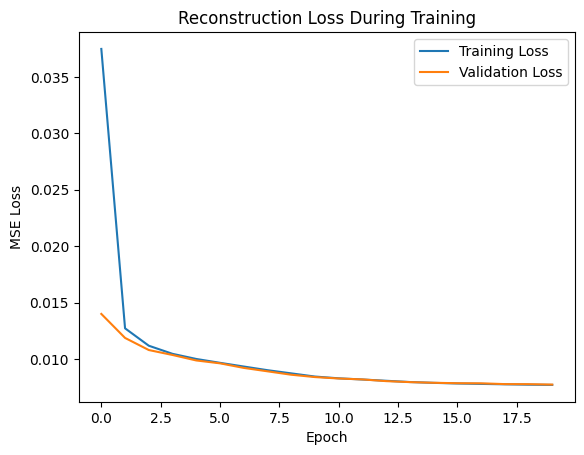

In [13]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Reconstruction Loss During Training')
plt.legend()
plt.show()

In [14]:
# Generate reconstructed images
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

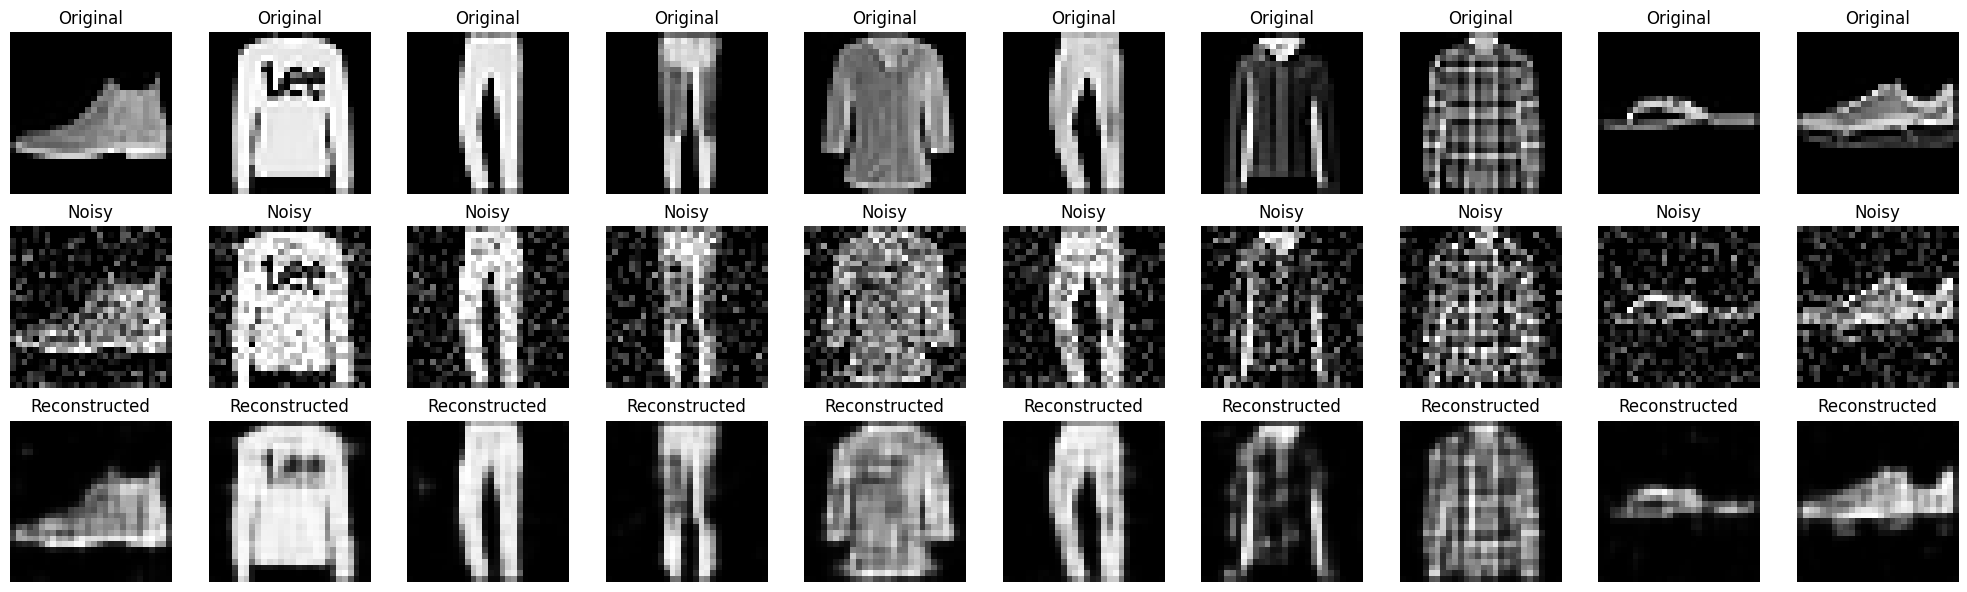

In [15]:
# Visualize original, noisy, and reconstructed images
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(tf.squeeze(x_test[i]), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Noisy image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(tf.squeeze(x_test_noisy[i]), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Reconstructed image
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(tf.squeeze(decoded_imgs[i]), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

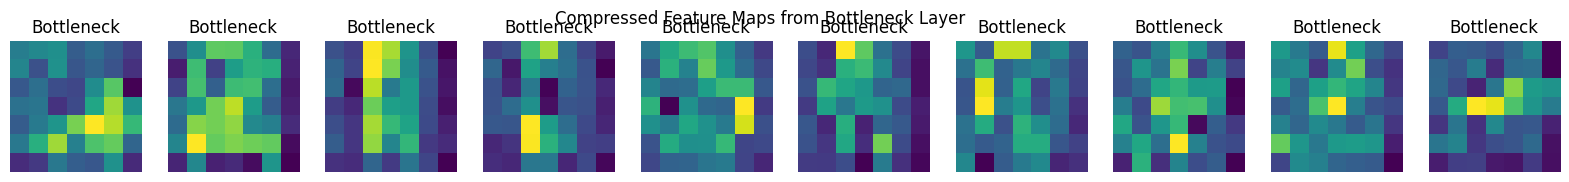

In [17]:
# Bottleneck Visualization (Feature Map)
# We'll take mean projection of encoded feature map
bottlenecks = encoded_imgs[:10]
plt.figure(figsize=(20, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    bottleneck_projection = np.mean(bottlenecks[i], axis=-1)  # Mean across channels
    plt.imshow(bottleneck_projection, cmap='viridis')
    plt.title("Bottleneck")
    plt.axis('off')
plt.suptitle("Compressed Feature Maps from Bottleneck Layer\n")
plt.show()